# SSD Evaluation Tutorial

This is a brief tutorial that explains how compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms. You can find details about these computation methods [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#sec:ap).

As an example we'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: I that in case you would like to evaluate a model on MS COCO, I would recommend to follow the [MS COCO evaluation notebook](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_evaluation_COCO.ipynb) instead, because it can produce the results format required by the MS COCO evaluation server and uses the official MS COCO evaluation code, which computes the mAP slightly differently from the Pascal VOC method.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results. The models that were trained on MS COCO and fine-tuned on Pascal VOC require the MS COCO scaling factors, not the Pascal VOC scaling factors.

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.
W0726 11:17:54.260719 140560894240064 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 36
model_mode = 'inference'

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'ssd300_belgas_epoch-32_loss-5.8048_val_loss-6.1943.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W0726 11:17:55.677369 140560894240064 deprecation_wrapper.py:119] From /mnt/sjfhome/misu/ssd_keras/ssd_venv/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0726 11:17:55.678575 140560894240064 deprecation_wrapper.py:119] From /mnt/sjfhome/misu/ssd_keras/ssd_venv/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0726 11:17:55.700077 140560894240064 deprecation_wrapper.py:119] From /mnt/sjfhome/misu/ssd_keras/ssd_venv/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 11:17:55.701304 140560894240064 deprecation_wrapper.py:119] From /mnt/sjfhome/misu/ssd_keras/ssd_venv/lib64/python3.6/site-packages/keras/backend/tens

Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

In [4]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
# model_path = 'path/to/trained/model.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
# ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

# K.clear_session() # Clear previous models from memory.

# model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
#                                                'L2Normalization': L2Normalization,
#                                                'DecodeDetections': DecodeDetections,
#                                                'compute_loss': ssd_loss.compute_loss})

## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [5]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
images_dir = '../datasets/images'
labels_file_test = '../datasets/local_groundtruth_test.csv'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['Adidas',
 'Adidas-text',
 'Airness',
 'BFGoodrich',
 'Base',
 'Bik',
 'Bouigues',
 'Bridgestone',
 'Bridgestone-text',
 'Carglass',
 'Citroen',
 'Citroen-text',
 'CocaCola',
 'Cofidis',
 'Dexia',
 'ELeclerc',
 'Ferrari',
 'Gucci',
 'Kia',
 'Mercedes',
 'Nike',
 'Peugeot',
 'Puma',
 'Puma-text',
 'Quick',
 'Reebok',
 'Roche',
 'SNCF',
 'Shell',
 'Standard_Liege',
 'StellaArtois',
 'TNT',
 'Total',
 'US_President',
 'Umbro',
 'VRT',
 'Veolia']

dataset.parse_csv(images_dir,labels_file_test,['image_name','xmin','xmax','ymin','ymax','class_id'])

## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [6]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=1,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.1,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 770

Producing predictions batch-wise: 100%|██████████| 770/770 [01:50<00:00,  8.33it/s]
Matching predictions to ground truth, class 1/36.: 100%|██████████| 56/56 [00:00<00:00, 2551.39it/s]
No predictions for class 2/36
Matching predictions to ground truth, class 3/36.: 100%|██████████| 2537/2537 [00:00<00:00, 16984.76it/s]
Matching predictions to ground truth, class 4/36.: 100%|██████████| 315/315 [00:00<00:00, 18312.44it/s]
Matching predictions to ground truth, class 5/36.: 100%|██████████| 405/405 [00:00<00:00, 9015.75it/s]
Matching predictions to ground truth, class 6/36.: 100%|██████████| 4/4 [00:00<00:00, 2807.90it/s]
Matching predictions to ground truth, class 7/36.: 100%|██████████| 11/11 [00:00<00:00, 5552.70it/s]
Matching predictions to ground truth, class 8/36.: 100%|██████████| 260/260 [00:00<00:00, 13390.79it/s]
Matching predictions to ground truth, class 9/36.: 100%|██████████| 34/34 [00:00<00:00, 13735.92it/s]
Matching predicti

/mnt/sjfhome/misu/ssd_keras/eval_utils/average_precision_evaluator.py:778: RuntimeWarning: invalid value encountered in true_divide
  cumulative_recall = tp / self.num_gt_per_class[class_id] # 1D array with shape `(num_predictions,)`
/mnt/sjfhome/misu/ssd_keras/eval_utils/average_precision_evaluator.py:840: RuntimeWarning: invalid value encountered in greater_equal
  cum_prec_recall_greater_t = cumulative_precision[cumulative_recall >= t]


## 4. Visualize the results

Let's take a look:

In [10]:
len(average_precisions),len(classes)

(37, 37)

In [11]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Adidas-text   AP    0.32
Airness       AP    0.0
BFGoodrich    AP    0.139
Base          AP    0.118
Bik           AP    0.169
Bouigues      AP    0.0
Bridgestone   AP    0.0
Bridgestone-textAP    0.083
Carglass      AP    0.087
Citroen       AP    0.085
Citroen-text  AP    0.106
CocaCola      AP    0.006
Cofidis       AP    0.1
Dexia         AP    0.077
ELeclerc      AP    0.0
Ferrari       AP    0.151
Gucci         AP    0.0
Kia           AP    0.154
Mercedes      AP    0.049
Nike          AP    0.164
Peugeot       AP    0.0
Puma          AP    0.143
Puma-text     AP    0.0
Quick         AP    0.19
Reebok        AP    0.0
Roche         AP    0.0
SNCF          AP    0.0
Shell         AP    0.315
Standard_LiegeAP    0.078
StellaArtois  AP    0.209
TNT           AP    0.128
Total         AP    0.04
US_President  AP    1.0
Umbro         AP    0.039
VRT           AP    0.0
Veolia        AP    0.045

              mAP   0.111


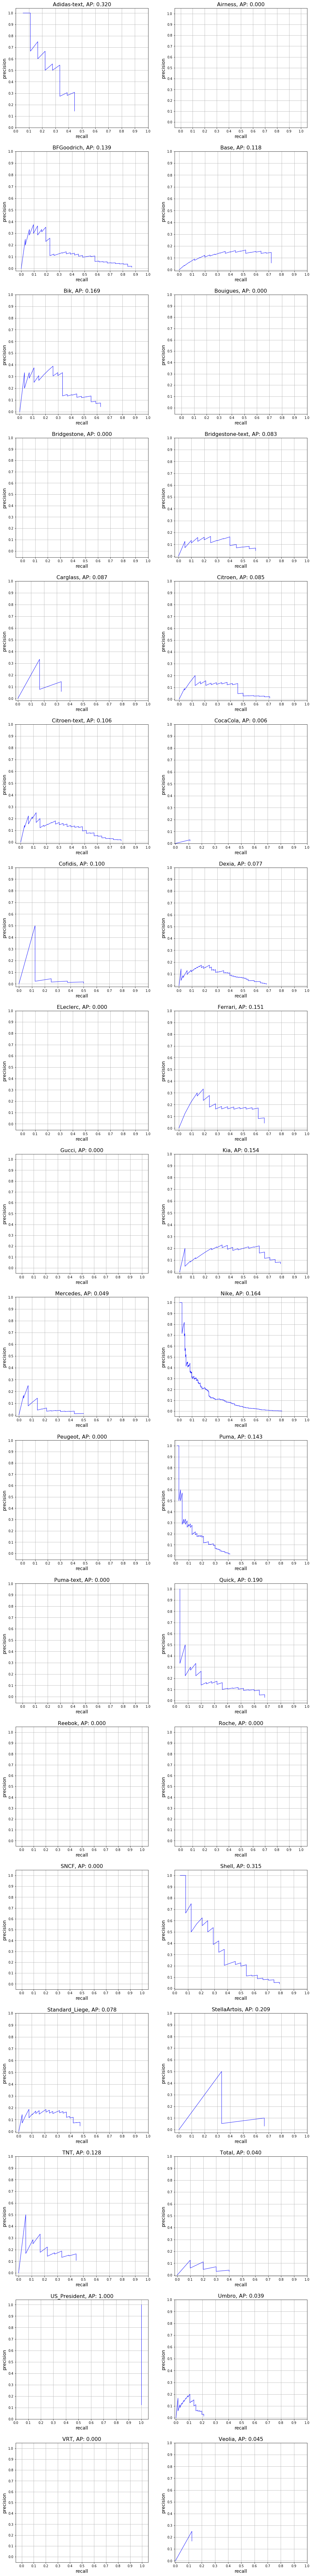

In [12]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [13]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 1/36.: 100%|██████████| 56/56 [00:00<00:00, 12471.12it/s]
No predictions for class 2/36
Matching predictions to ground truth, class 3/36.: 100%|██████████| 2537/2537 [00:00<00:00, 10674.22it/s]
Matching predictions to ground truth, class 4/36.: 100%|██████████| 315/315 [00:00<00:00, 19798.09it/s]
Matching predictions to ground truth, class 5/36.: 100%|██████████| 405/405 [00:00<00:00, 9273.15it/s]
Matching predictions to ground truth, class 6/36.: 100%|██████████| 4/4 [00:00<00:00, 2798.07it/s]
Matching predictions to ground truth, class 7/36.: 100%|██████████| 11/11 [00:00<00:00, 7119.96it/s]
Matching predictions to ground truth, class 8/36.: 100%|██████████| 260/260 [00:00<00:00, 8019.52it/s]
Matching predictions to ground truth, class 9/36.: 100%|██████████| 34/34 [00:00<00:00, 7039.85it/s]
Matching predictions to ground truth, class 10/36.: 100%|██████████| 1735/1735 [00:00<00:00, 16171.16it/s]
Matching predictions to ground truth, class 

In [14]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Adidas-text   AP    0.221
Airness       AP    0.0
BFGoodrich    AP    0.13
Base          AP    0.118
Bik           AP    0.134
Bouigues      AP    0.0
Bridgestone   AP    0.0
Bridgestone-textAP    0.079
Carglass      AP    0.111
Citroen       AP    0.064
Citroen-text  AP    0.098
CocaCola      AP    0.0
Cofidis       AP    0.134
Dexia         AP    0.07
ELeclerc      AP    0.0
Ferrari       AP    0.117
Gucci         AP    0.0
Kia           AP    0.157
Mercedes      AP    0.018
Nike          AP    0.095
Peugeot       AP    0.0
Puma          AP    0.082
Puma-text     AP    0.0
Quick         AP    0.118
Reebok        AP    0.0
Roche         AP    nan
SNCF          AP    0.0
Shell         AP    0.287
Standard_LiegeAP    0.07
StellaArtois  AP    0.0
TNT           AP    0.134
Total         AP    0.043
US_President  AP    0.0
Umbro         AP    0.009
VRT           AP    0.0
Veolia        AP    0.0

              mAP   nan
